# Global scale experiment

## Setup

In [1]:
# !pip install seaborn pyarrow plotly

In [1]:
import pandas as pd
import numpy as np
import os, sys, glob, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import scipy
import plotly.io as pio
import plotly.express as px
pio.renderers.default = 'iframe'
sys.path.append("../../scripts/face")
from postprocessing_metadata import summarize_enrichedFeaturesByAttribute, summarize_enrichedFeaturesByIdentity, compute_interEntropyByAttribute, parse_metadataBoolean, L_CELEBA_ATTRIBUTES

In [16]:
df_dataset = pd.read_csv(os.path.expanduser("~")+"/tda-face-recognition/data/CelebA/df_dataset.csv")
print(f"df_dataset shape: {df_dataset.shape}")
mask_retina = df_dataset["retina_n_faces_detected"]==1
df_dataset = df_dataset.loc[mask_retina].reset_index(drop=True)
d_emb = {}
for path_embeddings in glob.glob(os.path.expanduser("~")+"/tda-face-recognition/data/embeddings/CelebA/*.npy"):
    model_name, architecture, _ = re.split("_|\.", os.path.basename(path_embeddings))
    if architecture!="sfnet20":
        d_emb[(model_name, architecture)] = {}
        d_emb[(model_name, architecture)]["embeddings"] = np.load(path_embeddings)[mask_retina]
        assert d_emb[(model_name, architecture)]["embeddings"].shape[0]==df_dataset.shape[0]
print(f"df_dataset shape: {df_dataset.shape}")
display(df_dataset.head(3))

df_dataset shape: (70838, 66)
df_dataset shape: (66871, 66)


,file_basename,identity,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,path,retina_n_faces_detected,rgb_r,rgb_g,rgb_b,hsv_h,hsv_s,hsv_v,keep_embeddings_retina_facenet,keep_embeddings_retina_arcface
0,000001.jpg,2880,-1,1,1,-1,-1,-1,-1,-1,...,../../data/CelebA/CelebA/000001.jpg,1,186.621253,138.771205,111.080676,18.028938,121.680963,186.676020,True,True
1,000003.jpg,8692,-1,-1,-1,-1,-1,-1,1,-1,...,../../data/CelebA/CelebA/000003.jpg,1,137.332430,122.143256,112.725367,40.700016,56.606665,141.362883,False,False
2,000004.jpg,5805,-1,-1,1,-1,-1,-1,-1,-1,...,../../data/CelebA/CelebA/000004.jpg,1,112.412707,80.612723,61.390545,13.296397,99.557318,112.458147,True,False


## Metadata entropies

In [4]:
# instantiation of df_attributes and df_identities
df_attributes = summarize_enrichedFeaturesByAttribute(df_dataset)
df_identities = summarize_enrichedFeaturesByIdentity(df_dataset)

# creation of df_mia (mean of attribute by identity and attribute) and df_hia (entropy by identity and attribute)
df_mia = df_dataset[L_CELEBA_ATTRIBUTES + ["identity"]].groupby("identity").agg("mean").reset_index()
df_mia = df_mia.melt(id_vars=["identity"]).rename(columns={"variable":"attribute", "value":"id_average"})
df_hia = df_dataset[L_CELEBA_ATTRIBUTES + ["identity"]].groupby("identity").agg(lambda u:  scipy.stats.entropy(np.unique(np.array(list(u)), return_counts=True)[1])).reset_index()
df_hia = df_hia.melt(id_vars=["identity"]).rename(columns={"variable":"attribute", "value":"id_entropy"})

# df_attributes
df_attributes = pd.concat([df_attributes, pd.DataFrame(df_dataset[L_CELEBA_ATTRIBUTES].mean().rename("global_average"))])
df_attributes = pd.merge(df_attributes
                     ,compute_interEntropyByAttribute(df_mia, L_CELEBA_ATTRIBUTES)
                     ,how="left", right_index=True, left_index=True)
df_attributes = pd.merge(df_attributes
                     ,df_hia.groupby("attribute")["id_entropy"].mean().rename("intra_entropy")
                     ,how="left", right_index=True, left_index=True)
df_attributes = df_attributes.loc[L_CELEBA_ATTRIBUTES].sort_values(by="global_average")

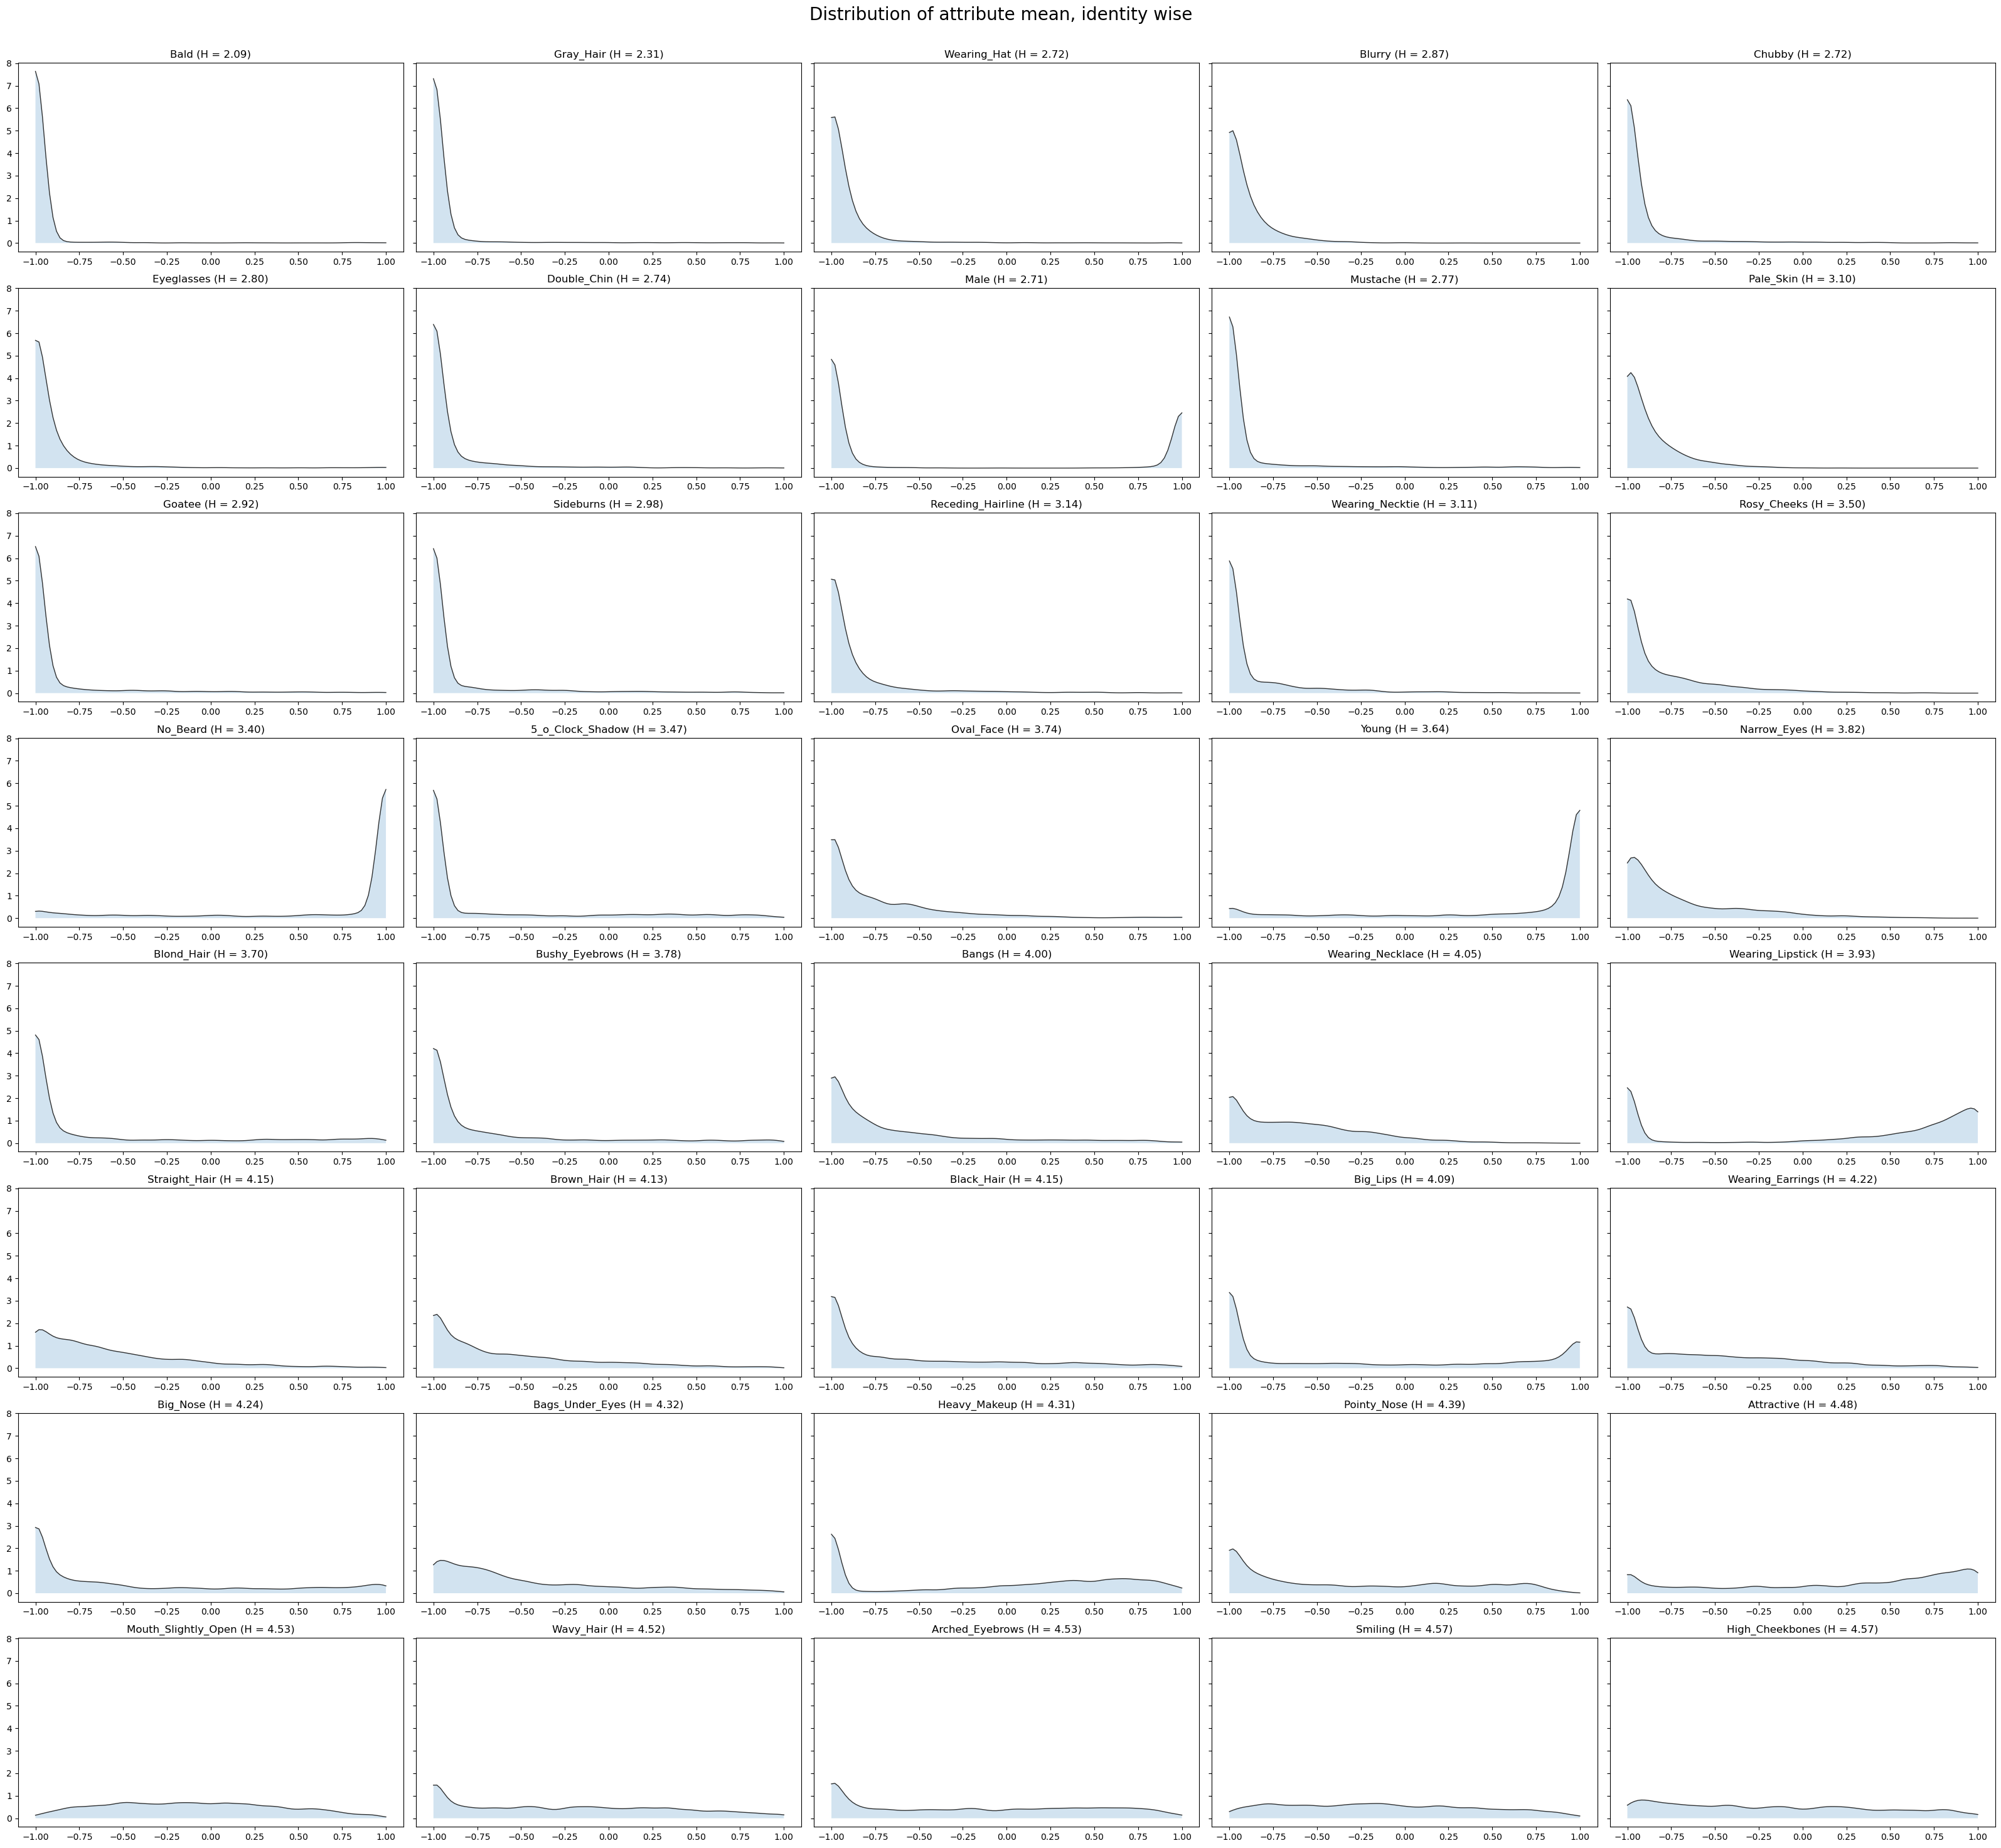

In [5]:
fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(8*4,5*6), sharey=True)
n_states = 101
for i, attribute in enumerate(df_attributes.sort_values(by="inter_entropy").index):
    arr = df_mia.loc[df_mia["attribute"]==attribute, "id_average"].values
    kde = KernelDensity(bandwidth=0.05, kernel="gaussian")
    kde.fit(arr.reshape(-1,1))
    x = np.linspace(-1,1,n_states)
    logprob = kde.score_samples(x.reshape(-1,1))
    prob = np.exp(logprob)/(np.exp(logprob).sum())
    H = scipy.stats.entropy(prob)
    row, col = i//5, i%5
    ax[row, col].plot(x,np.exp(logprob), linewidth=1, c="black", alpha=.8)
    ax[row, col].fill_between(x,np.exp(logprob), 0, alpha=0.2)
    ax[row, col].set_title(f"{attribute} (H = {H:.2f})")
fig.suptitle("Distribution of attribute mean, identity wise", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig("saved_plots/distrib_mean.pdf",format="pdf", bbox_inches="tight")

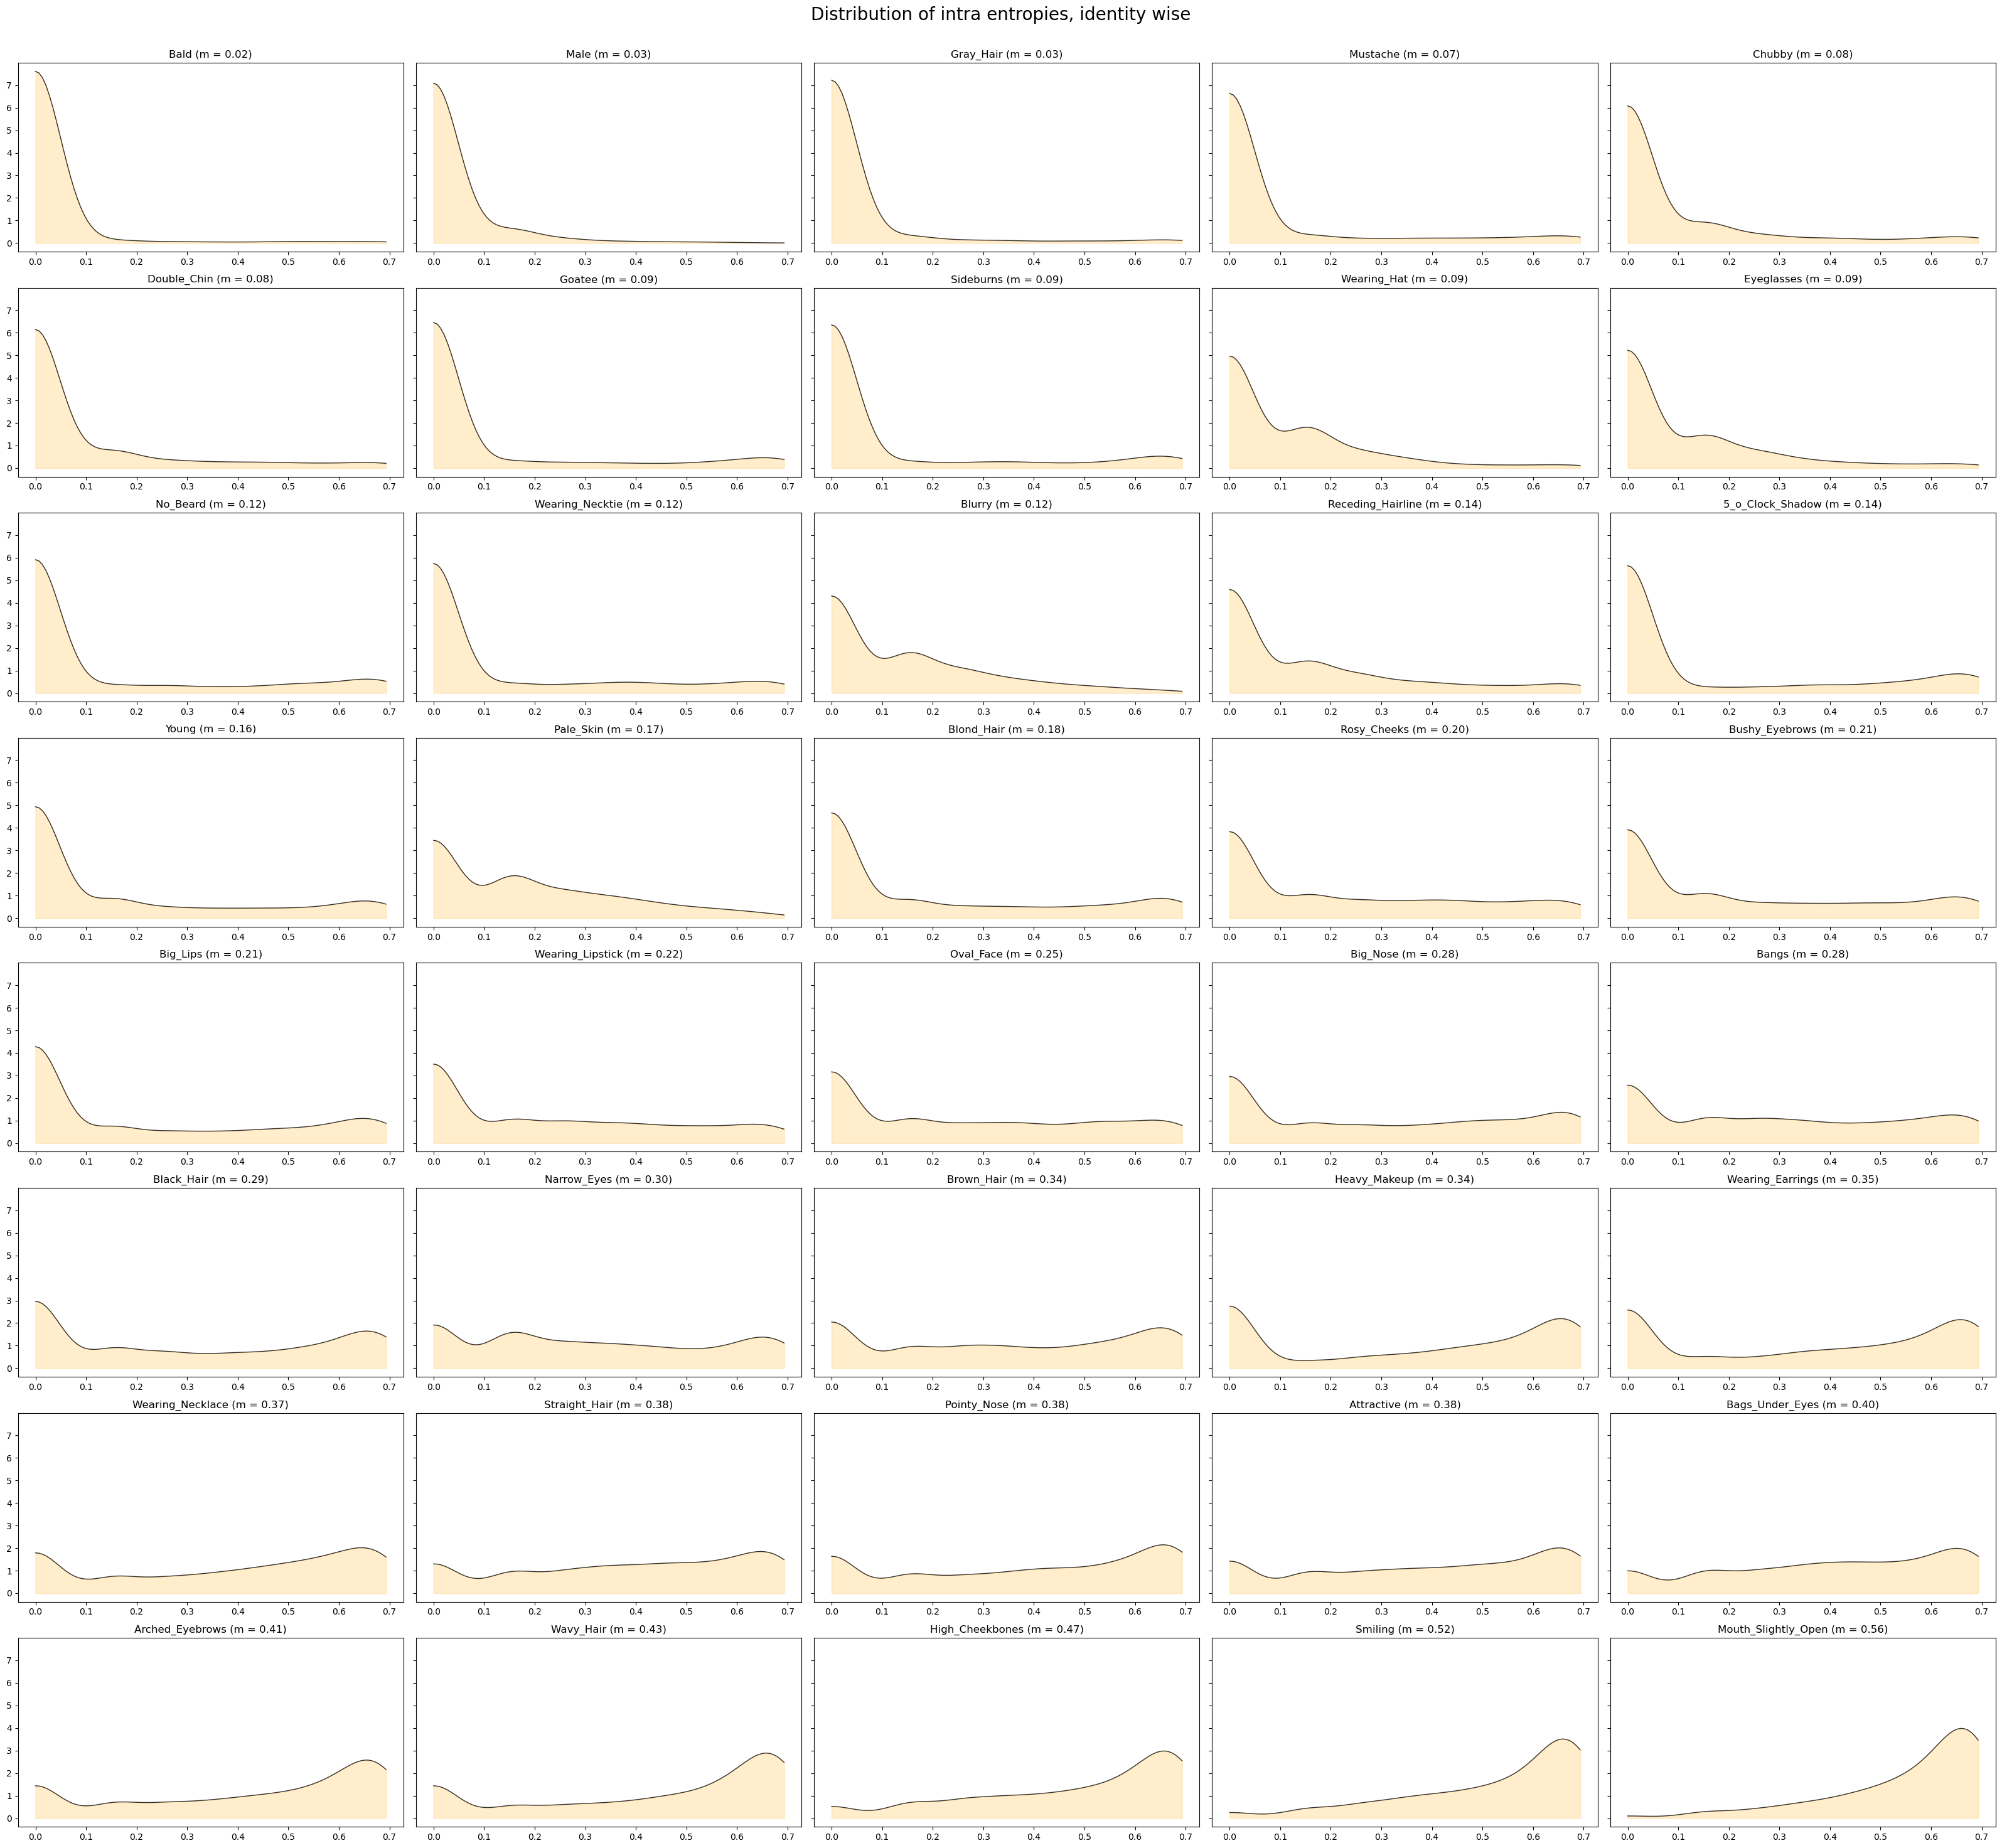

In [6]:
fig, ax = plt.subplots(nrows=8, ncols=5, figsize=(8*4,5*6), sharey=True)
n_states = 101
x = np.linspace(0,-np.log(1/2),n_states)
for i, attribute in enumerate(df_attributes.sort_values(by="intra_entropy").index):
    arr = df_hia.loc[df_hia["attribute"]==attribute, "id_entropy"].values
    kde = KernelDensity(bandwidth=0.05, kernel="gaussian")
    kde.fit(arr.reshape(-1,1))
    logprob = kde.score_samples(x.reshape(-1,1))
    prob = np.exp(logprob)/(np.exp(logprob).sum())
    row, col = i//5, i%5
    ax[row, col].plot(x,np.exp(logprob), linewidth=1, c="black", alpha=.8)
    ax[row, col].fill_between(x,np.exp(logprob), 0, alpha=0.2, color="orange")
    ax[row, col].set_title(f"{attribute} (m = {arr.mean():.2f})")
fig.suptitle("Distribution of intra entropies, identity wise", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig("saved_plots/distrib_intra_entropy.pdf",format="pdf", bbox_inches="tight")

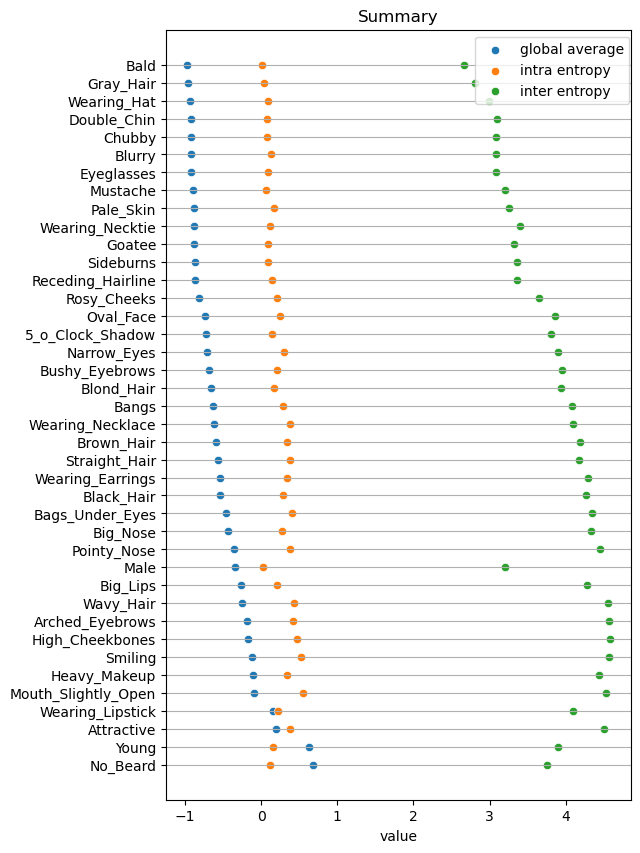

In [7]:
plt.figure(figsize=(6,10))
# plt.xlim([-1,1])
plt.grid(axis='y')
sns.scatterplot(df_attributes, y=df_attributes.index, x="global_average", label="global average")
sns.scatterplot(df_attributes, y=df_attributes.index, x="intra_entropy", label="intra entropy")
sns.scatterplot(df_attributes, y=df_attributes.index, x="inter_entropy", label="inter entropy")
plt.xlabel("value")
plt.legend(bbox_to_anchor=(0.65, 1.0), loc='upper left')
plt.title("Summary")
plt.savefig("saved_plots/summaries_celeba.pdf",format="pdf", bbox_inches="tight")

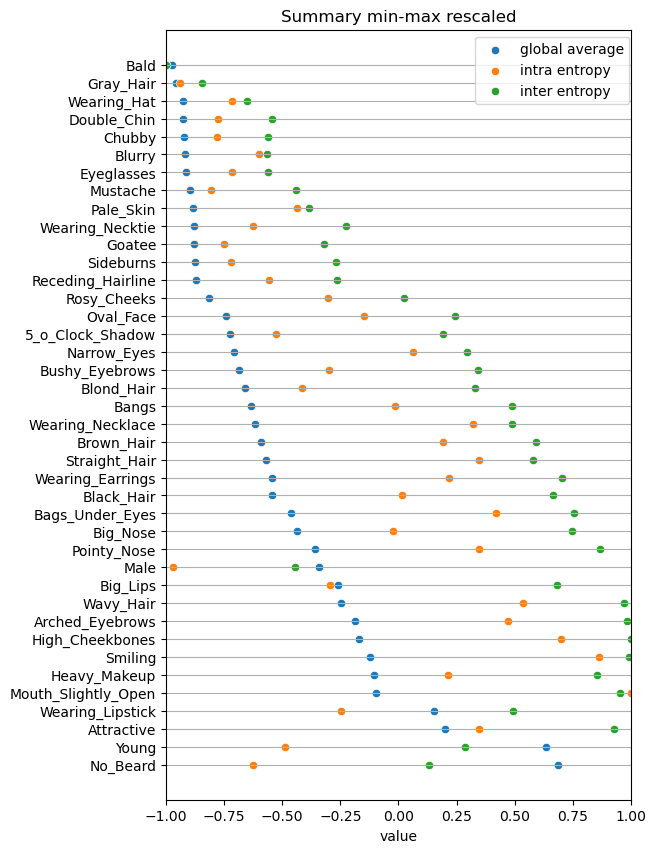

In [8]:
df_attributes["inter_entropy_rescaled"] = ((df_attributes["inter_entropy"]-(df_attributes["inter_entropy"]).min())/(df_attributes["inter_entropy"].max()-(df_attributes["inter_entropy"]).min()))*2-1
df_attributes["intra_entropy_rescaled"] = ((df_attributes["intra_entropy"]-(df_attributes["intra_entropy"]).min())/(df_attributes["intra_entropy"].max()-(df_attributes["intra_entropy"]).min()))*2-1

plt.figure(figsize=(6,10))
plt.xlim([-1,1])
plt.grid(axis='y')
sns.scatterplot(df_attributes, y=df_attributes.index, x="global_average", label="global average")
sns.scatterplot(df_attributes, y=df_attributes.index, x="intra_entropy_rescaled", label="intra entropy")
sns.scatterplot(df_attributes, y=df_attributes.index, x="inter_entropy_rescaled", label="inter entropy")
plt.xlabel("value")
plt.legend(bbox_to_anchor=(0.65, 1.0), loc='upper left')
plt.title("Summary min-max rescaled")
plt.savefig("saved_plots/summaries_celeba_rescaled.pdf",format="pdf", bbox_inches="tight")

## Distances and KS statistic

In [13]:
def get_pointClouds(a_embeddings, df_dataset, attribute, max_samples=500, verbose=False):
    df_a = df_dataset.loc[df_dataset[attribute]==1].sample(frac=1).drop_duplicates(subset="identity")
    df_aBarre = df_dataset.loc[df_dataset[attribute]==-1].sample(frac=1).drop_duplicates(subset="identity")
    n_samples = min(max_samples, len(df_a), len(df_aBarre))
    if n_samples!=max_samples and verbose:
        print(f"""Attribute: {attribute}\nNot enough samples for attribute: max_samples, len(df_a), len(df_aBarre) = {max_samples, len(df_a), len(df_aBarre)}\nUsing {n_samples} samples\n""")
    a_indices_a = df_a.iloc[:n_samples].index
    a_indices_aBarre = df_aBarre.iloc[:n_samples].index
    X_a = a_embeddings[a_indices_a]
    X_aBarre = a_embeddings[a_indices_aBarre]
    return X_a, X_aBarre

def get_distancesList(X1, X2, metric, k=0):
    dm = scipy.spatial.distance.cdist(X1, X2, metric=metric)
    return dm[np.triu_indices(len(dm), k=k)]

def compute_distanceLists(X_a, X_aBarre, metric, return_n_sample=False):
    X_total = np.concatenate((X_a, X_aBarre))
    # get the distances arrays
    a_a = get_distancesList(X_a, X_a, metric, k=1)
    a_aBarre = get_distancesList(X_aBarre, X_aBarre, metric, k=1)
    a_total = get_distancesList(X_total, X_total, metric, k=1)
    a_cross = scipy.spatial.distance.cdist(X_a, X_aBarre, metric=metric).flatten()
    if return_n_sample:
        n_sample = len(X_a)
        assert n_sample==len(X_aBarre)
        return a_a, a_aBarre, a_total, a_cross, n_sample
    else:
        return a_a, a_aBarre, a_total, a_cross

def sample_distances(a_emb, df_dataset, attribute, metric, verbose=False, return_n_sample=False):
    X_a, X_aBarre = get_pointClouds(a_emb, df_dataset, attribute, verbose=verbose)
    return compute_distanceLists(X_a, X_aBarre, metric=metric, return_n_sample=return_n_sample)

def compute_cumulativeDistanceDistribution(a_a, a_aBarre, a_total, a_cross):
    d = {"a_a":[]
        ,"a_aBarre":[]
        ,"a_total":[]
        ,"a_cross":[]}
    max_dist_global = max(a_a.max(),a_aBarre.max(),a_total.max(),a_cross.max())
    min_dist_global = min(a_a.min(),a_aBarre.min(),a_total.min(),a_cross.min())
    x = np.linspace(min_dist_global, max_dist_global)
    for dist_threshold in x:
        d["a_a"].append((a_a<dist_threshold).mean())
        d["a_aBarre"].append((a_aBarre<dist_threshold).mean())
        d["a_total"].append((a_total<dist_threshold).mean())
        d["a_cross"].append((a_cross<dist_threshold).mean())
    d_cumulative = {k:np.array(v) for k,v in d.items()}
    return x, d_cumulative

def plot_cumulativeDistributions(x, d_cumulative):
    fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

    # left plot
    for k, v in d_cumulative.items():
        ax[0].plot(x, v, label=k)
    ax[0].legend()
    ax[0].set_ylabel("cdf of distances")

    # right plot
    ax[1].grid()
    ax[1].plot(x, d_cumulative["a_a"]-d_cumulative["a_cross"], label="a_a - a_cross")
    ax[1].plot(x, d_cumulative["a_aBarre"]-d_cumulative["a_cross"], label="a_aBarre - a_cross")
    ax[1].plot(x, np.zeros_like(x), c="red")
    ax[1].legend()
    ax[1].set_ylabel("value")
    ax[1].set_xlabel("distance")

Attribute: Bald
Not enough samples for attribute: max_samples, len(df_a), len(df_aBarre) = (500, 112, 2357)
Using 112 samples



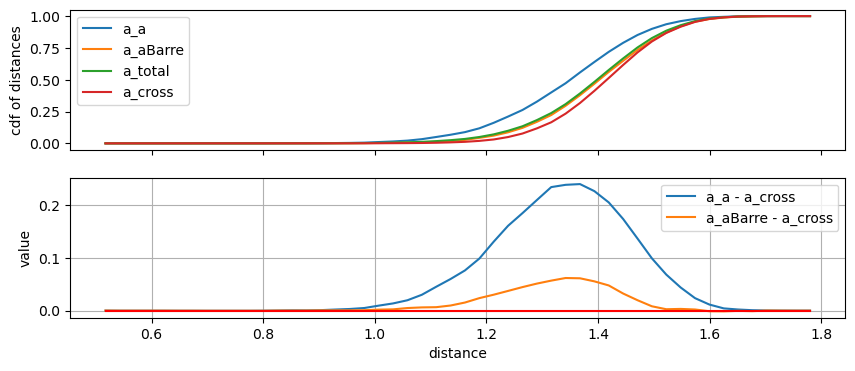

In [10]:
attribute = "Bald"

X_a, X_aBarre = get_pointClouds(d_emb[("facenet","iresnetv1")]["embeddings"], df_dataset, attribute, verbose=True)
a_a, a_aBarre, a_total, a_cross = compute_distanceLists(X_a, X_aBarre, metric="euclidean", return_n_sample=False)
x, d_cumulative = compute_cumulativeDistanceDistribution(a_a, a_aBarre, a_total, a_cross)
plot_cumulativeDistributions(x, d_cumulative)

In [11]:
d = { "attribute":[]
     ,"modality":[]
    }
for k in d_emb.keys():
    model_name, architecture = k
    d[f"stat_{model_name}_{architecture}"] = []
    d[f"pvalue_{model_name}_{architecture}"] = []

for attribute in df_attributes.index:
    print(f"Measuring ks stats for: {attribute}")
    
    # primary key
    d["attribute"].extend([attribute]*2)
    d["modality"].append("positive")
    d["modality"].append("negative")
    
    for d_k, d_v in d_emb.items():
        model_name, architecture = d_k
        if model_name in ("facenet"):
            metric = "euclidean"
        elif model_name in ("arcface", "adaface", "spherefacer"):
            metric = "cosine"
        a_a, a_aBarre, a_total, a_cross = sample_distances(d_v["embeddings"], df_dataset, attribute, metric=metric)
        stat_a, pvalue_a = scipy.stats.ks_2samp(a_a, a_cross)    
        stat_aBarre, pvalue_aBarre = scipy.stats.ks_2samp(a_aBarre, a_cross)
        d[f"stat_{model_name}_{architecture}"].append(stat_a)
        d[f"stat_{model_name}_{architecture}"].append(stat_aBarre)
        d[f"pvalue_{model_name}_{architecture}"].append(pvalue_a)
        d[f"pvalue_{model_name}_{architecture}"].append(pvalue_aBarre)
df_modality = pd.DataFrame(d)
df_modality["label"] = df_modality["attribute"] + "_" + df_modality["modality"]
df_modality = df_modality.set_index("label")
df_modality

Measuring ks stats for: Bald
Measuring ks stats for: Gray_Hair
Measuring ks stats for: Wearing_Hat
Measuring ks stats for: Double_Chin
Measuring ks stats for: Chubby
Measuring ks stats for: Blurry
Measuring ks stats for: Eyeglasses
Measuring ks stats for: Mustache
Measuring ks stats for: Pale_Skin
Measuring ks stats for: Wearing_Necktie
Measuring ks stats for: Goatee
Measuring ks stats for: Sideburns
Measuring ks stats for: Receding_Hairline
Measuring ks stats for: Rosy_Cheeks
Measuring ks stats for: Oval_Face
Measuring ks stats for: 5_o_Clock_Shadow
Measuring ks stats for: Narrow_Eyes
Measuring ks stats for: Bushy_Eyebrows
Measuring ks stats for: Blond_Hair
Measuring ks stats for: Bangs
Measuring ks stats for: Wearing_Necklace
Measuring ks stats for: Brown_Hair
Measuring ks stats for: Straight_Hair
Measuring ks stats for: Wearing_Earrings
Measuring ks stats for: Black_Hair
Measuring ks stats for: Bags_Under_Eyes
Measuring ks stats for: Big_Nose
Measuring ks stats for: Pointy_Nose
Meas

,attribute,modality,stat_facenet_iresnetv1,pvalue_facenet_iresnetv1,stat_arcface_r50,pvalue_arcface_r50,stat_spherefacer_iresnet100,pvalue_spherefacer_iresnet100,stat_arcface_r18,pvalue_arcface_r18,stat_adaface_r18,pvalue_adaface_r18
label,,,,,,,,,,,,
Bald_positive,Bald,positive,0.247132,4.763775e-224,0.061508,4.124962e-14,0.078645,8.347433e-23,0.080796,4.780333e-24,0.081432,2.020952e-24
Bald_negative,Bald,negative,0.063431,5.571260e-15,0.041197,1.447103e-06,0.057024,3.454821e-12,0.044348,1.533424e-07,0.033003,2.284842e-04
Gray_Hair_positive,Gray_Hair,positive,0.183360,0.000000e+00,0.035366,4.788491e-19,0.047444,6.123683e-34,0.048974,3.889184e-36,0.060628,3.636541e-55
Gray_Hair_negative,Gray_Hair,negative,0.060772,1.993898e-55,0.023481,1.235821e-08,0.025491,4.228947e-10,0.031522,3.224393e-15,0.020209,1.656749e-06
Wearing_Hat_positive,Wearing_Hat,positive,0.045448,8.205972e-150,0.010869,5.738509e-09,0.012973,1.352817e-12,0.018683,1.151434e-25,0.028548,2.346938e-59
...,...,...,...,...,...,...,...,...,...,...,...,...
Attractive_negative,Attractive,negative,0.009997,1.183493e-07,0.005041,2.899452e-02,0.008340,1.863282e-05,0.008750,5.803398e-06,0.008242,2.445456e-05
Young_positive,Young,positive,0.066787,0.000000e+00,0.021916,3.737549e-35,0.033988,5.844820e-84,0.041536,3.405217e-125,0.028626,1.117760e-59
Young_negative,Young,negative,0.078968,0.000000e+00,0.010259,4.901246e-08,0.016786,8.429886e-21,0.029723,2.615703e-64,0.017561,1.005811e-22


In [12]:
# add count of modality
df = df_dataset[list(df_attributes.index)].melt().groupby(["variable", "value"]).size().rename("count").to_frame().reset_index().rename(columns={"variable":"attribute", "value":"modality"})
df["modality"] = df["modality"].map({-1:"negative", 1:"positive"})
df["label"] = df["attribute"] + "_" + df["modality"]
df = df.set_index("label").drop(columns=["attribute", "modality"])
df_modality = df_modality.join(df, how="inner")
df_modality.head()
# aggregate at the attribute level
df = df_modality.groupby("attribute").agg({c:["max", "mean"] for c in df_modality.columns if c.startswith("stat")})
df.columns = ["_".join(x) for x in df.columns]
df_attributes = df.join(df_attributes, how="inner")
# add weighted aggregation
for col_stat in [c for c in df_modality.columns if c.startswith("stat")]:
    df_attributes[col_stat+"weighted"] = df_modality.groupby("attribute").apply(lambda u: u["count"]*u[col_stat]).groupby("attribute").sum()

In [13]:
# correlation of the ks statistic and entropies
d = {"column":[],
    "statistic":[],
    "pvalue":[],
    "entropy":[],}
for col_stat in [x for x in df_attributes.columns if "stat" in x]:
    res = scipy.stats.spearmanr(df_attributes[col_stat], df_attributes["inter_entropy"])
    d["column"].append(col_stat)
    d["statistic"].append(res.statistic)
    d["pvalue"].append(res.pvalue)
    d["entropy"].append("inter")
    res = scipy.stats.spearmanr(df_attributes[col_stat], df_attributes["intra_entropy"])
    d["column"].append(col_stat)
    d["statistic"].append(res.statistic)
    d["pvalue"].append(res.pvalue)
    d["entropy"].append("intra")
df_correlations = pd.DataFrame(d)
df_correlations

,column,statistic,pvalue,entropy
0,stat_facenet_iresnetv1_max,-0.368668,0.019240,inter
1,stat_facenet_iresnetv1_max,-0.544841,0.000278,intra
2,stat_facenet_iresnetv1_mean,-0.451782,0.003429,inter
3,stat_facenet_iresnetv1_mean,-0.649343,0.000006,intra
4,stat_arcface_r50_max,-0.339587,0.032049,inter
5,stat_arcface_r50_max,-0.527017,0.000476,intra
6,stat_arcface_r50_mean,-0.358349,0.023176,inter
7,stat_arcface_r50_mean,-0.556098,0.000195,intra
8,stat_spherefacer_iresnet100_max,-0.320826,0.043545,inter
9,stat_spherefacer_iresnet100_max,-0.521388,0.000561,intra


## Discriminative power

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [ ]:
%%time

scoring = ["accuracy", "balanced_accuracy"]

d = {"model_name":[],
    "architecture":[],
    "attribute":[],}
for s in scoring:
    d[f"{s}"] = []
    d[f"{s}_std"] = []

for k, d_v in d_emb.items():
    print(k)
    model_name, architecture = k
    for attribute in df_attributes.index:
        print(attribute)
        clf = LogisticRegression(max_iter=1000)
        y = df_dataset[attribute]
        X = d_v["embeddings"]
        if model_name in ("arcface", "adaface", "spherefacer"):
            X = X/(np.linalg.norm(X, axis=1).reshape(-1, 1))  # normalization to put everything on the sphere
        scores = cross_validate(clf, X, y, cv=5, scoring=scoring)
        d["model_name"].append(model_name)
        d["architecture"].append(architecture)
        d["attribute"].append(attribute)
        for score in scoring:
            d[score].append(scores[f"test_{score}"].mean())
            d[f"{score}_std"].append(scores[f"test_{score}"].std())

df_discriminative_power = pd.DataFrame(d)
df_discriminative_power["label"] = df_discriminative_power["model_name"]+"_"+df_discriminative_power["architecture"]

## Saving dataframes

In [ ]:
df_modality.to_csv("saved_data/df_modality.csv")
df_attributes.to_csv("saved_data/df_attributes.csv")
df_correlations.to_csv("saved_data/df_correlations.csv", index=False)
df_discriminative_power.to_csv("saved_data/df_discriminative_power.csv", index=False)

# Visualization

## Loading dataframes

Objects:

| Dataframe    | Key | Information |
| -------- | ------- |------- |
| df_modality| (attribute, modality)| statistics by model, pvalue, count|
| df_attributes| (attribute) | statistics by model, entropies |
| df_correlations| (model_architecture_aggregation, entropy) | correlation statistic, pvalue|
| df_discriminative_power  | (model_name, architecture, attribute) | accuracies on logistic regression |


In [2]:
df_modality = pd.read_csv("saved_data/df_modality.csv", index_col=0)
df_attributes = pd.read_csv("saved_data/df_attributes.csv", index_col=0)
df_correlations = pd.read_csv("saved_data/df_correlations.csv", index_col=0)
df_discriminative_power = pd.read_csv("saved_data/df_discriminative_power.csv")

## Plots Pierrick

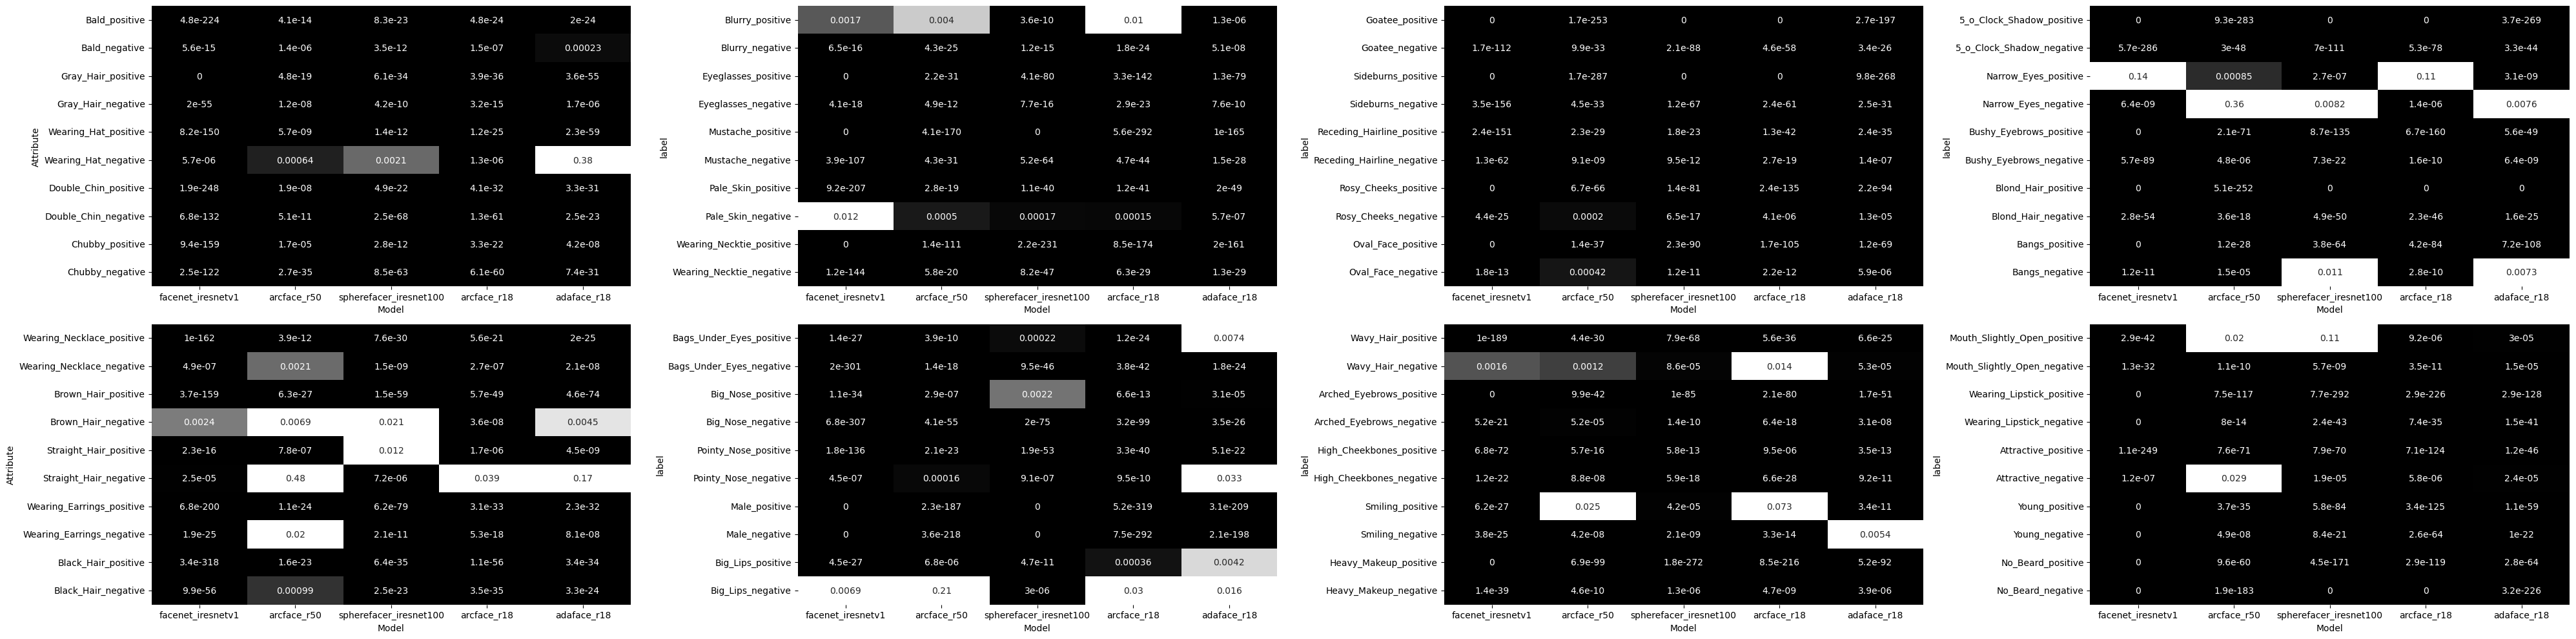

In [3]:
vmin=0
vmax=0.005

df = df_modality[[col for col in df_modality.columns if re.search("^pvalue_", col) is not None]].copy()
df.columns = [re.findall("pvalue_(.*)", col)[0] for col in df.columns]

fig, axes = plt.subplots(2, 4, figsize=(40,10))
# fig.suptitle("P-value significance", loc="center")

for i in range(2):
    s = sns.heatmap(df.iloc[40*i:40*i+10], cbar=False, ax=axes[i,0], annot=True, vmin=vmin, vmax=vmax, cmap="gray")
    s.set(xlabel='Model', ylabel='Attribute')
    for j in range(1,4): 
        s = sns.heatmap(df.iloc[40*i+10*j:40*i+10*j+10], cbar=False, ax=axes[i,j], annot=True, vmin=vmin, vmax=vmax, cmap="gray")
        s.set(xlabel='Model')

fig.tight_layout()
plt.savefig("saved_plots/pvalues.pdf",format="pdf", bbox_inches="tight")

In [4]:
stat_model1 = "stat_arcface_r50"  # choose first two columns from df_modality statistic columns
stat_model2 = "stat_facenet_iresnetv1"

value_max = df_modality[[stat_model1,stat_model2]].max().max()
fig = px.scatter(df_modality.reset_index(), x=stat_model1, y=stat_model2, width=800, height=800, hover_data=["label"])
fig.update_layout(yaxis_range=[0,value_max])
fig.update_layout(xaxis_range=[0,value_max])

In [5]:
stat_model1 = "stat_arcface_r50"  # choose first two columns from df_modality statistic columns
stat_model2 = "stat_facenet_iresnetv1"

value_max = df_modality[[stat_model1,stat_model2]].max().max()
fig = px.scatter(df_modality.reset_index(), x=stat_model1, y=stat_model2, width=800, height=800, hover_data=["label"], color="modality")
fig.update_layout(yaxis_range=[0,value_max])
fig.update_layout(xaxis_range=[0,value_max])

In [6]:
df = df_attributes.copy()
df["rank_facenet"] = df["stat_facenet_iresnetv1_max"].rank(ascending=False)
df["rank_arcface"] = df["stat_arcface_r50_max"].rank(ascending=False)
fig = px.scatter(df.reset_index(), x="rank_arcface", y="rank_facenet", width=800, height=800, hover_data=["index"], size="intra_entropy")
fig

In [7]:
df = df_attributes.copy()
value_max = df[["stat_arcface_r50_max","stat_facenet_iresnetv1_max"]].max().max() * 1.1
# df["inter_entropy"] = df["inter_entropy_rescaled"]+1.1
df["intra_entropy"] = df["intra_entropy_rescaled"]+1.1
fig = px.scatter(df.reset_index(), x="stat_arcface_r50_max", y="stat_facenet_iresnetv1_max", width=800, height=800, hover_data=["index"], size="intra_entropy")
fig.update_layout(yaxis_range=[0,value_max])
fig.update_layout(xaxis_range=[0,value_max])
fig

In [8]:
# df_discriminative_power
val_min = df_discriminative_power[["accuracy", "balanced_accuracy"]].values.flatten().min()
val_max = df_discriminative_power[["accuracy", "balanced_accuracy"]].values.flatten().max()

fig = px.scatter(df_discriminative_power, x="balanced_accuracy", y="accuracy", width=800, height=800, hover_data=["attribute"], color="label")
fig.update_layout(yaxis_range=[val_min,val_max])
fig.update_layout(xaxis_range=[val_min,val_max])
fig

In [9]:
df_correlations

,statistic,pvalue,entropy
column,,,
stat_facenet_iresnetv1_max,-0.368668,0.019240,inter
stat_facenet_iresnetv1_max,-0.544841,0.000278,intra
stat_facenet_iresnetv1_mean,-0.451782,0.003429,inter
stat_facenet_iresnetv1_mean,-0.649343,0.000006,intra
stat_arcface_r50_max,-0.339587,0.032049,inter
stat_arcface_r50_max,-0.527017,0.000476,intra
stat_arcface_r50_mean,-0.358349,0.023176,inter
stat_arcface_r50_mean,-0.556098,0.000195,intra
stat_spherefacer_iresnet100_max,-0.320826,0.043545,inter


In [10]:
# df_correlations

fig = px.bar(df_correlations.reset_index().sort_values(by="statistic"), x="column", y="statistic", barmode='group', color="entropy")
fig

## Plots Marco

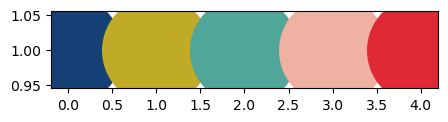

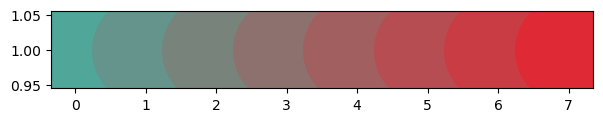

In [11]:
palette = ["#144075","#bfab26","#4fa699","#efb1a1", "#df2a35"]
palette_continuous = ["#4FA699","#64948B","#78837C","#8D716E","#A15F60","#B64D52","#CA3C43","#DF2A35"]

f = plt.figure(figsize = (5,1))
for i in range(len(palette)):
    plt.scatter(i,1,color = palette[i], s = 6000)

f = plt.figure(figsize = (7,1))
for i in range(len(palette_continuous)):
    plt.scatter(i,1,color = palette_continuous[i], s = 6000)


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [17]:
attribute = "Male"

X_a, X_aBarre = get_pointClouds(d_emb[("facenet","iresnetv1")]["embeddings"], df_dataset, attribute, verbose=True)
a_a, a_aBarre, a_total, a_cross = compute_distanceLists(X_a, X_aBarre, metric="euclidean", return_n_sample=False)
x, d_cumulative = compute_cumulativeDistanceDistribution(a_a, a_aBarre, a_total, a_cross)

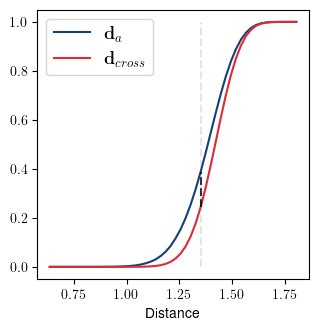

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5), sharex=True)

# left plot
i = 0
for k, v in d_cumulative.items():   
    if k!= "a_total" and k!="a_aBarre":
        ax.plot(x, v, label=k, color = palette[i])
        i += 4

maxid = np.argmax(np.abs(d_cumulative['a_a']-d_cumulative['a_cross']))

ax.vlines(x[maxid],0,1,color = 'gray',alpha = 0.2,linestyle = '--')
ax.vlines(x[maxid],d_cumulative['a_cross'][maxid],d_cumulative['a_a'][maxid],
         color = 'k',alpha = 0.8,linestyle = '--')

ax.legend(['$\mathbf{d}_a$','$\mathbf{d}_{cross}$'], fontsize = 13)
ax.set_ylabel("")
ax.set_xlabel("Distance")
plt.savefig("saved_plots/cdf_ks.pdf",format="pdf", bbox_inches="tight")


In [19]:
## FACENET vs ARCFACE

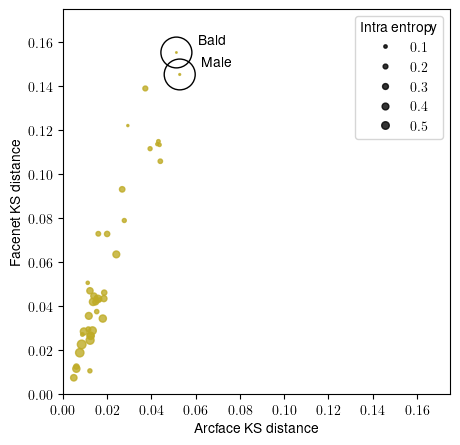

In [20]:
df = df_attributes.copy()
x = df["stat_arcface_r50_mean"].values
y = df["stat_facenet_iresnetv1_mean"].values

fig, ax = plt.subplots(figsize = (5,5))

sentropy = df["intra_entropy"].values

sc = plt.scatter(x,y, s = sentropy*70, color = palette[1], alpha = 0.8)
plt.xlim([0,0.175])
plt.ylim([0,0.175])


maxid = np.argmax(x)
maxlabel = df.index[maxid]
max_y = y[maxid]
max_x = x[maxid]

x[maxid] = 0
premaxid = np.argmax(x)
premaxlabel = df.index[premaxid]
premax_y = y[premaxid]
premax_x = x[premaxid]

circ = plt.Circle((max_x,max_y),0.007, fill = False)
ax.add_patch(circ)

circ1 = plt.Circle((premax_x,premax_y),0.007, fill = False)
ax.add_patch(circ1)

ax.text(max_x+0.01,max_y+0.004,maxlabel)
ax.text(premax_x+0.01,premax_y+0.004,premaxlabel)

ax.set_xlabel('Arcface KS distance')
ax.set_ylabel('Facenet KS distance')

els = sc.legend_elements("sizes", num=6)[0]
els1 =  ['$\\mathdefault{0.1}$','$\\mathdefault{0.2}$','$\\mathdefault{0.3}$','$\\mathdefault{0.4}$','$\\mathdefault{0.5}$']
ax.legend(els,els1, loc="upper right", title="Intra entropy")
plt.savefig("saved_plots/ks_entropy.pdf",format="pdf", bbox_inches="tight")



Text(0, 0.5, 'Facenet KS distance')

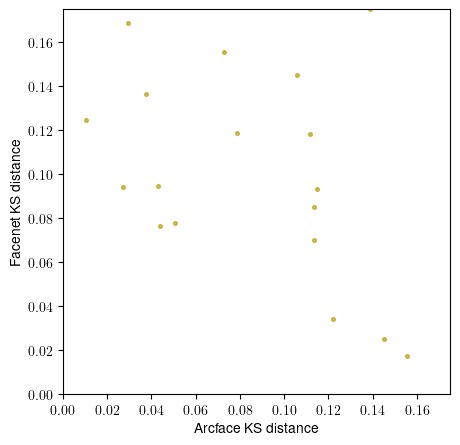

In [21]:
df = df_attributes.copy()
x = df["stat_facenet_iresnetv1_mean"].values
y = df["intra_entropy"].values

fig, ax = plt.subplots(figsize = (5,5))


sc = plt.scatter(x,y, s = 7, color = palette[1], alpha = 0.8)
plt.xlim([0,0.175])
plt.ylim([0,0.175])


ax.set_xlabel('Arcface KS distance')
ax.set_ylabel('Facenet KS distance')


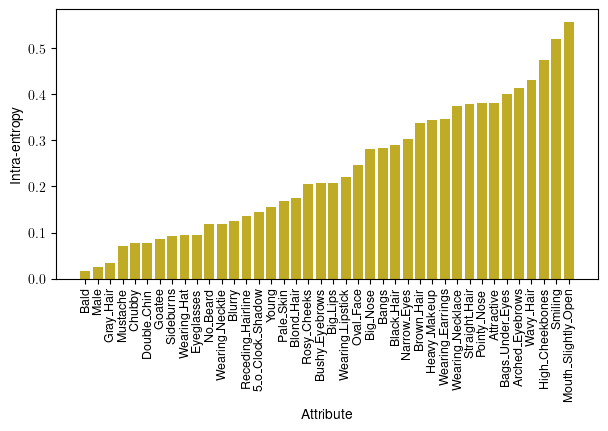

In [22]:
fig, ax = plt.subplots(figsize = (7,3.5))
df2 = df.sort_values('intra_entropy')
ax.bar(df2['intra_entropy'].index,df2['intra_entropy'].values, color = palette[1],alpha = 1)
plt.ylabel("Intra-entropy")
plt.xlabel("Attribute")

plt.xticks(range(len(df2['intra_entropy'].index)),labels = df2['intra_entropy'].index, rotation = 90, fontsize = 9);
plt.savefig("saved_plots/entropies.pdf",format="pdf", bbox_inches="tight")


# staged

In [ ]:
raise ValueError("You shall not pass")

# <>